In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/jeju/train.csv')
test = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/jeju/test.csv')
trade = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/jeju/international_trade.csv')
sample = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/jeju/sample_submission.csv')

In [3]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

In [10]:
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2


In [11]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train['price(원/kg)']

test_x = test.drop(columns=['ID', 'timestamp'])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
test_x_sc = scaler.transform(test_x)

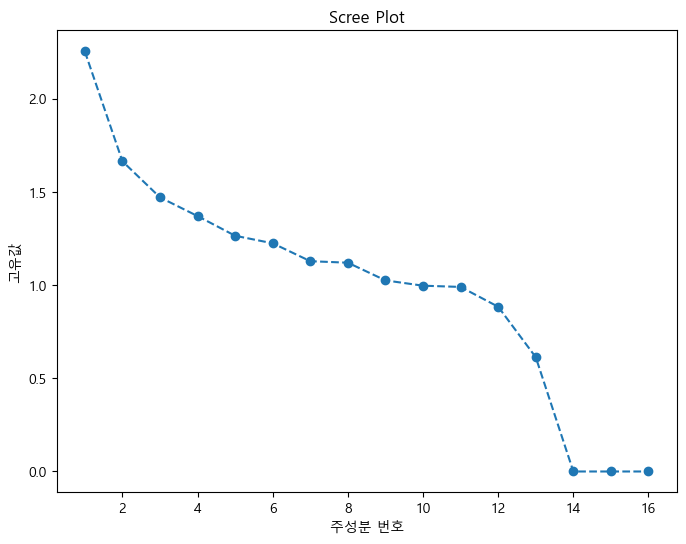

80% 이상의 설명된 분산을 가지는 주성분의 개수: 10


In [23]:
from sklearn.decomposition import PCA

# PCA 모델 생성
pca = PCA()
pca.fit(X_train_sc)

# 주성분별 고유값 추출
eigenvalues = pca.explained_variance_

# 스크리 플롯 그리기
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.xlabel('주성분 번호')
plt.ylabel('고유값')
plt.title('Scree Plot')
plt.show()

# 누적 설명된 분산의 비율 계산
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# 80% 이상의 설명된 분산을 가지는 주성분 개수 확인
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1

# 결과 출력
print(f"80% 이상의 설명된 분산을 가지는 주성분의 개수: {n_components}")

In [40]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
test_x_pca = pca.transform(test_x_sc)

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 그리드 서치를 위한 매개변수 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost 회귀 모델 생성
xgbr = xgb.XGBRegressor()

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_search.fit(X_train_sc, y_train)

# 최적의 파라미터 및 점수 출력
print("최적 파라미터:", grid_search.best_params_)
print("최고 점수:", grid_search.best_score_)

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
최고 점수: 0.7278026522958623


In [56]:
xgbr = xgb.XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.2, subsample=1, colsample_bytree=1)
xgbr.fit(X_train_sc, y_train)
y_pred = xgbr.predict(X_test_sc)

print('mae:',mean_absolute_error(y_pred, y_test))
print('mape:',mean_absolute_percentage_error(y_pred, y_test))
print('mse:',mean_squared_error(y_pred, y_test))

sc_pred = xgbr.predict(test_x_sc)

mae: 528.1339094448922
mape: 0.9263689245555158
mse: 1085521.311881156


In [58]:
sc_pred = pd.DataFrame(sc_pred)
submission2 = pd.concat([sample, sc_pred], axis=1)
submission2.drop('answer', axis=1, inplace=True)
submission2 = submission2.rename(columns={0: 'answer'})

submission2.to_csv('submission2.csv', index=False)

In [42]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 그리드 서치를 위한 매개변수 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost 회귀 모델 생성
xgbr = xgb.XGBRegressor()

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_search.fit(X_train_pca, y_train)

# 최적의 파라미터 및 점수 출력
print("최적 파라미터:", grid_search.best_params_)
print("최고 점수:", grid_search.best_score_)

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.9}
최고 점수: 0.5913618547062549


In [59]:
xgbr = xgb.XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1)
xgbr.fit(X_train_pca, y_train)
y_pred_pca = xgbr.predict(X_test_pca)

print('mae:',mean_absolute_error(y_pred_pca, y_test))
print('mape:',mean_absolute_percentage_error(y_pred_pca, y_test))
print('mse:',mean_squared_error(y_pred_pca, y_test))

pca_pred = xgbr.predict(test_x_pca)

mae: 705.5514812750347
mape: 1.180764759989635
mse: 1727116.4637591129


In [60]:
pca_pred = pd.DataFrame(pca_pred)
submission_jeju = pd.concat([sample, pca_pred], axis=1)
submission_jeju.drop('answer', axis=1, inplace=True)
submission_jeju = submission_jeju.rename(columns={0: 'answer'})

submission_jeju.to_csv('submission_jeju.csv', index=False)

In [4]:
def english(data, col):
    data[col] = data[col].apply(lambda x: 'TG' if '감귤' in x else x)
    data[col] = data[col].apply(lambda x: 'BC' if '브로콜리' in x else x)
    data[col] = data[col].apply(lambda x: 'RD' if '무' in x else x)
    data[col] = data[col].apply(lambda x: 'CR' if '당근' in x else x)
    data[col] = data[col].apply(lambda x: 'CB' if '양배추' in x else x)
    
    return data

In [5]:
english(trade, '품목명')
trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,BC,160,1,638913,563,-562
4,2019-01,CB,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


In [6]:
filtered = trade[(trade['품목명'] == 'TG') | (trade['품목명'] == 'BC') | (trade['품목명'] == 'RD') | (trade['품목명'] == 'CR') | (trade['품목명'] == 'CB')]
filtered

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01,BC,160,1,638913,563,-562
4,2019-01,CB,0,0,7580,38,-38
5,2019-01,CB,184650,94,395802,90,4
8,2019-01,CR,23150,22,7466150,2955,-2934
12,2019-01,RD,2627,23,94529,464,-441
...,...,...,...,...,...,...,...
1250,2023-02,CB,13188,13,377456,104,-91
1253,2023-02,CR,22510,20,9260020,3758,-3737
1254,2023-02,RD,4000,4,2,0,4
1258,2023-02,RD,1319,14,104566,454,-440


In [7]:
filtered['기간'] = pd.to_datetime(filtered['기간'])
train['timestamp'] = pd.to_datetime(train['timestamp'])
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 3 to 1264
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기간      306 non-null    datetime64[ns]
 1   품목명     306 non-null    object        
 2   수출 중량   306 non-null    int64         
 3   수출 금액   306 non-null    int64         
 4   수입 중량   306 non-null    int64         
 5   수입 금액   306 non-null    int64         
 6   무역수지    306 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 19.1+ KB


In [8]:
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2


In [9]:
test

,ID,timestamp,item,corporation,location,year,month,day
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,6
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,7
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,8
...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,2023,3,27
1088,RD_F_J_20230328,2023-03-28,RD,F,J,2023,3,28
1089,RD_F_J_20230329,2023-03-29,RD,F,J,2023,3,29
1090,RD_F_J_20230330,2023-03-30,RD,F,J,2023,3,30


In [96]:
train['기간'] = train['year'].astype(str) + '-' + train['month'].astype(str)
train['기간'] = pd.to_datetime(train['기간'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           59397 non-null  object        
 1   timestamp    59397 non-null  datetime64[ns]
 2   item         59397 non-null  object        
 3   corporation  59397 non-null  object        
 4   location     59397 non-null  object        
 5   supply(kg)   59397 non-null  float64       
 6   price(원/kg)  59397 non-null  float64       
 7   year         59397 non-null  int64         
 8   month        59397 non-null  int64         
 9   day          59397 non-null  int64         
 10  기간           59397 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 5.0+ MB


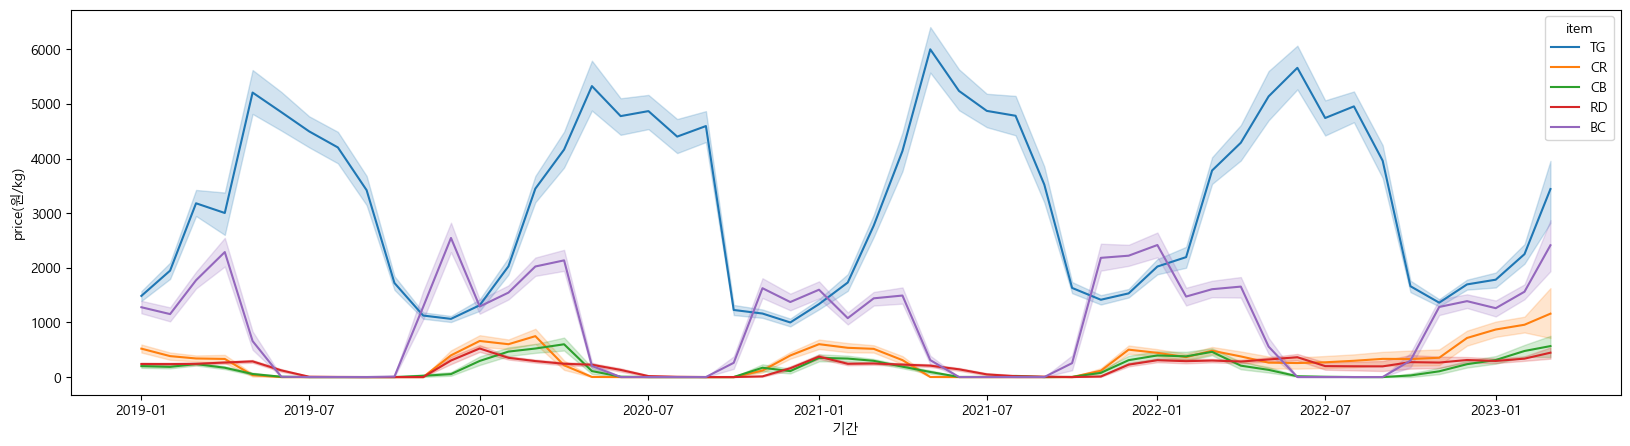

In [53]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=train, x='기간', y='price(원/kg)', hue='item')
plt.show()

<Figure size 2000x600 with 0 Axes>

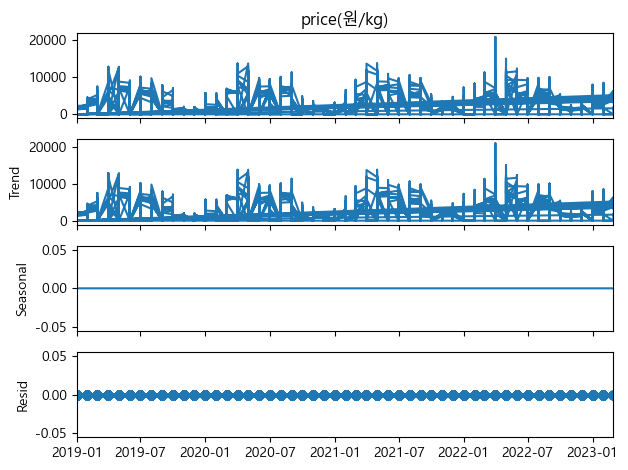

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

# '기간' 열을 datetime 형식으로 변환
train['기간'] = pd.to_datetime(train['기간'])

# '기간' 열을 인덱스로 설정
train.set_index('기간', inplace=True)

# 'item' 열이 'TG'인 데이터만 필터링하여 새로운 데이터프레임 생성
tg_data = train[train['item'] == 'TG']

# 가법 모델로 시계열 분해를 수행합니다.
result = seasonal_decompose(tg_data['price(원/kg)'], model='additive', period=1)

# 그래프 사이즈 조절
plt.figure(figsize=(20, 6))

# 시계열 분해 결과를 그래프로 나타냅니다.
result.plot()
plt.show()

In [111]:
train['item'].unique()

array(['TG', 'CR', 'CB', 'RD', 'BC'], dtype=object)

In [113]:
cr_data = train[train['item'] == 'CR']
cb_data = train[train['item'] == 'CB']
rd_data = train[train['item'] == 'RD']
bc_data = train[train['item'] == 'BC']

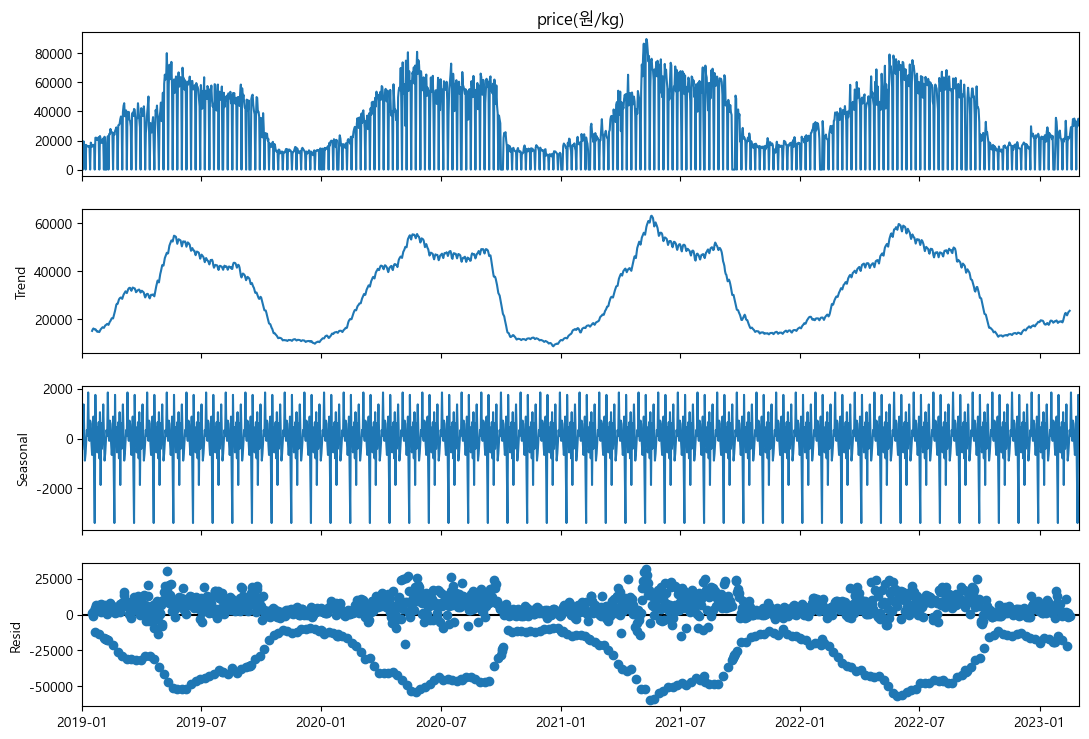

In [110]:
# 분해시계열 수행
result = seasonal_decompose(tg_data.groupby('timestamp')['price(원/kg)'].sum(), model='additive', period=30)  # 계절성 주기를 30으로 설정

# 시계열, 추세, 계절성, 잔차 그래프 플로팅 및 그래프 사이즈 조절
result.plot()
plt.gcf().set_size_inches(12, 8)
plt.show()

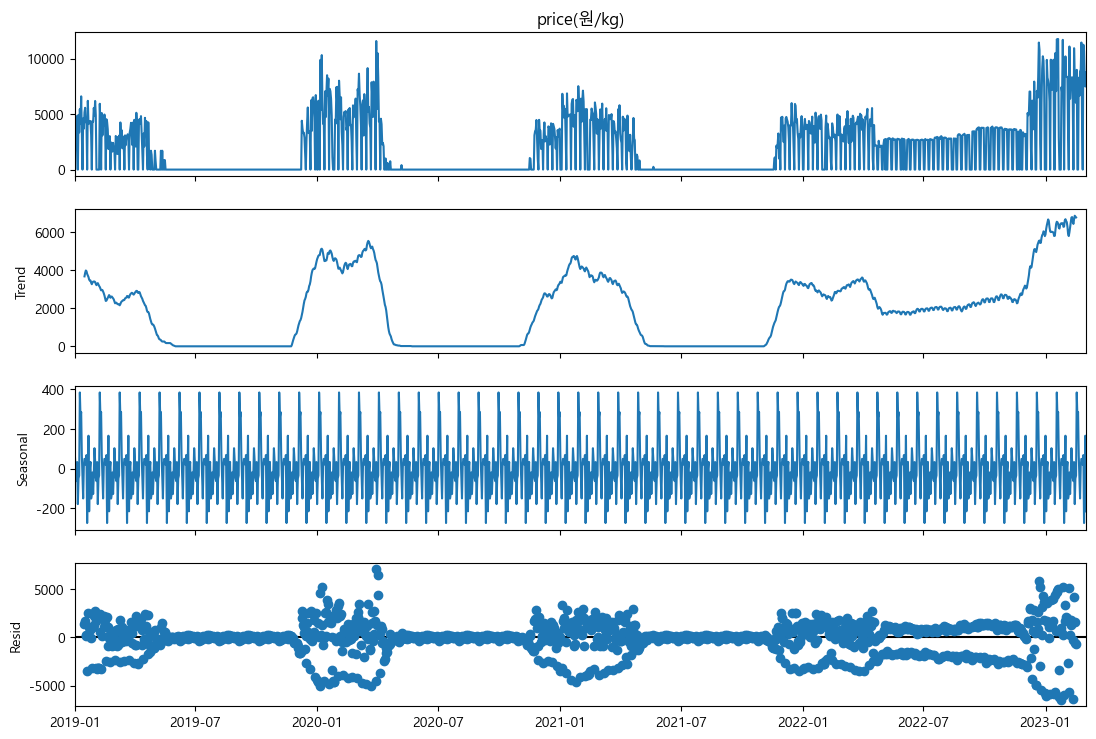

In [114]:
# 분해시계열 수행
result = seasonal_decompose(cr_data.groupby('timestamp')['price(원/kg)'].sum(), model='additive', period=30)  # 계절성 주기를 30으로 설정

# 시계열, 추세, 계절성, 잔차 그래프 플로팅 및 그래프 사이즈 조절
result.plot()
plt.gcf().set_size_inches(12, 8)
plt.show()